# **Network Exploration**

## **Imports**

In [1]:
import os
import sys
from pathlib import Path
from warnings import filterwarnings
from dotenv import load_dotenv
import tweepy
import numpy as np
import pandas as pd
import dask.dataframe as dd
import ast
from scipy.stats import gmean
import networkx as nx
import matplotlib.pyplot as plt
from main import get_user_description, get_user_ids


load_dotenv()
filterwarnings("ignore")

PATH = os.getcwd()
PROJECT = str(Path(PATH).parents[1])
TWITTER_USERNAME = os.getenv("TWITTER_USERNAME")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_API_BEARER_TOKEN = os.getenv("TWITTER_API_BEARER_TOKEN")
CLOUD_STORAGE_BUCKET = "gs://graph_data_science/twitter"

client = tweepy.Client(TWITTER_API_BEARER_TOKEN, wait_on_rate_limit=True)

In [2]:
def draw_graph(
    graph=None,
    edge_labels=None,
    pos=None,
    edge_color="black",
    width=1,
    linewidths=1,
    node_size=3500,
    node_color="black",
    alpha=0.9,
    font_color="w",
    font_size=16,
    fig_size=(20, 20),
    length=17,
    edge_label_font_color="red",
    title=None,
):
    """
    takes a graph and edge labels and draws a diagram. You need to pass edge labels
    if you are passing a graph parameters.
    For smaller subgraphs pass nx.circular_layout for pos.
    """

    if pos == None:
        pos = nx.spring_layout(graph)
    else:
        pos = pos
    fig = plt.figure(figsize=fig_size)
    if title != None:
        fig.suptitle(title)
    nx.draw(
        graph,
        pos=pos,
        edge_color=edge_color,
        width=width,
        linewidths=linewidths,
        node_size=node_size,
        node_color=node_color,
        alpha=alpha,
        font_color=font_color,
        font_size=font_size,
        labels={node: node for node in graph.nodes()},
    )

    nx.draw_networkx_edge_labels(
        graph,
        pos,
        edge_labels=edge_labels,
        font_color=edge_label_font_color,
        font_size=font_size,
    )
    plt.axis("off")
    plt.show()

def get_ego_graph(graph, edge_labels=None, node="Tom", radius=1):
    ego_graph = nx.ego_graph(graph, n=node, radius=radius)
    ego_edge_labels = dict()
    ego_node_labels = {node: node for node in ego_graph.nodes()}
    ego_edge_labels = dict()
    if edge_labels:
        keys = edge_labels.keys()
        for key in keys:
            if key in ego_graph.edges():
                ego_edge_labels[key] = edge_labels[key]
    return ego_graph, ego_edge_labels, 

## **Read**

### **Edges**

In [3]:
df = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/data/users_following*.csv").compute()
df.following = df.following.apply(ast.literal_eval)
df.head()

,user,following
0,1210565171107815429,"[1281443510, 632966383, 27631809, 14922097, 22..."
1,3432386097,"[33836629, 188343397, 235684766, 17268874, 439..."
2,1120633726478823425,[]
3,4398626122,[]
4,48008938,"[1464797992872034304, 630995607, 27493883, 123..."


In [4]:
df = df.explode('following')
df.user.value_counts()[:10]

17230018               5000
1263491240336769026    5000
2228878592             5000
119466953              5000
2261210518             5000
12609292               5000
24306387               4953
21862217               4879
1398479138             4636
12                     4550
Name: user, dtype: int64

### **Node Features**

In [5]:
nodes = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/data/node_features*.csv", dtype={'withheld': 'object'}).compute()
nodes.public_metrics = nodes.public_metrics.apply(ast.literal_eval)
print(nodes.shape)
nodes = nodes.iloc[:, :-4]
print(nodes.shape)
data_public_metrics = pd.json_normalize(nodes["public_metrics"])
nodes = pd.merge(nodes, data_public_metrics, left_index=True, right_index=True)
print(nodes.shape)
nodes.head()

(102296, 11)
(102296, 7)


,id,name,profile_image_url,public_metrics,username,verified,withheld
0,794433401591693312,Aran Komatsuzaki,https://pbs.twimg.com/profile_images/150798283...,"{'followers_count': 16111, 'following_count': ...",arankomatsuzaki,False,NaN
1,2509504696,Jericho Brown,https://pbs.twimg.com/profile_images/111968593...,"{'followers_count': 40468, 'following_count': ...",jerichobrown,True,NaN
2,1938030980,Angel Wicky,https://pbs.twimg.com/profile_images/144139505...,"{'followers_count': 355162, 'following_count':...",Angel_Wicky_II,True,NaN
3,335544910,AC Justice Project,https://pbs.twimg.com/profile_images/145415812...,"{'followers_count': 1049, 'following_count': 4...",ACJProject,False,NaN
4,2622261,Brian Ulicny,https://pbs.twimg.com/profile_images/730781652...,"{'followers_count': 796, 'following_count': 24...",bulicny,False,NaN
5,113509424,SB Running,https://pbs.twimg.com/profile_images/228211819...,"{'followers_count': 633, 'following_count': 45...",SBRunningCo,False,NaN
6,20972810,Knut Helge Risheim,https://pbs.twimg.com/profile_images/139926011...,"{'followers_count': 897, 'following_count': 10...",knuthelge,False,NaN
7,19662335,Mark Penn,https://pbs.twimg.com/profile_images/970757748...,"{'followers_count': 13263, 'following_count': ...",Mark_Penn,True,NaN
8,3009677047,The Sensible Centre,https://pbs.twimg.com/profile_images/142832814...,"{'followers_count': 17180, 'following_count': ...",sensiblecentre_,False,NaN
9,30935020,Northern Lass,https://pbs.twimg.com/profile_images/129710179...,"{'followers_count': 14632, 'following_count': ...",northerness,False,NaN


In [9]:
nodes.drop(columns=["public_metrics", "withheld"], inplace=True)
nodes.to_csv(f"{CLOUD_STORAGE_BUCKET}/data/processed/node_features_compressed.csv", index = False)

## **Graph and Measures**

In [5]:
#if you need a full graph including the user

user = client.get_user(
    username=TWITTER_USERNAME,
    user_fields=["id"],
).data.id
df_following = df.copy().dropna()
df_user = pd.DataFrame({"user": user, "following": df_following.user.unique()})

print(df_following.shape, df_user.shape)

df_with_user = pd.concat([df_user, df_following])
print(df_with_user.shape)

(157763, 2) (143, 2)
(157906, 2)


In [6]:
edges = df_with_user.copy().dropna()
edges.columns = ['source', 'target']
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)
edges['weight'] = 1
print(df.shape, edges.shape)

(157768, 2) (157906, 3)


In [7]:
G = nx.from_pandas_edgelist(
    edges,
    create_using=nx.DiGraph(),
    edge_attr=True
)

In [8]:
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
print(f"Average Clustering: {round(nx.average_clustering(G), 3)}")

Nodes: 114509, Edges: 157905
Average Clustering: 0.073


1427408443296657408
Nodes: 144, Edges: 1645
Average Clustering: 0.406


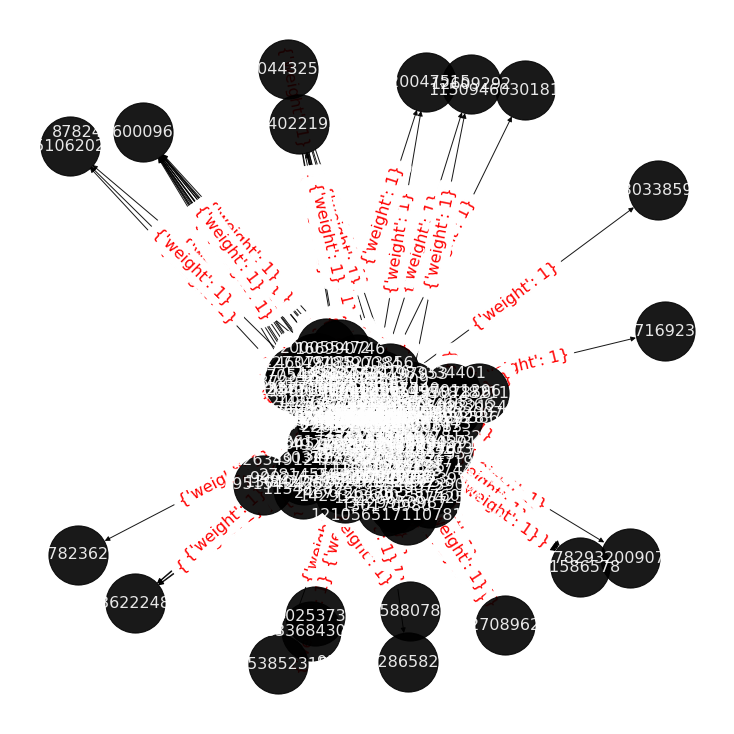

In [9]:
G_s, _ = get_ego_graph(G, node=user)
print(f"{user}")
print(f"Nodes: {len(G_s.nodes())}, Edges: {len(G_s.edges())}")
print(f"Average Clustering: {round(nx.average_clustering(G_s), 3)}")
# print(f"Small Worldness (>=1): {round(nx.algorithms.smallworld.sigma(G_s.to_undirected(), niter = 5), 3)}"): #takes forever
draw_graph(G_s, fig_size  = (10, 10))

elonmusk
Nodes: 114, Edges: 379
Average Clustering: 0.614


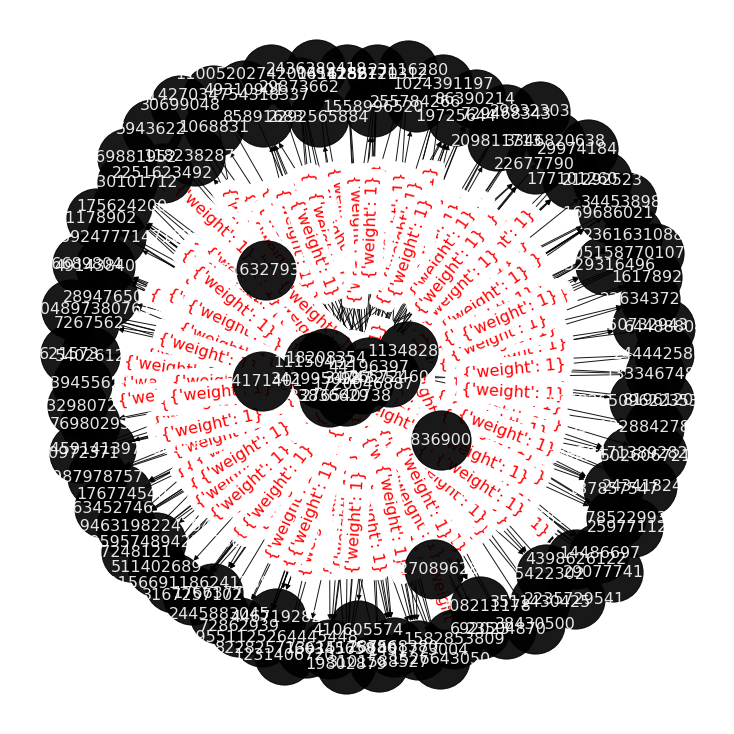

ImHardcory
Nodes: 723, Edges: 2094
Average Clustering: 0.474


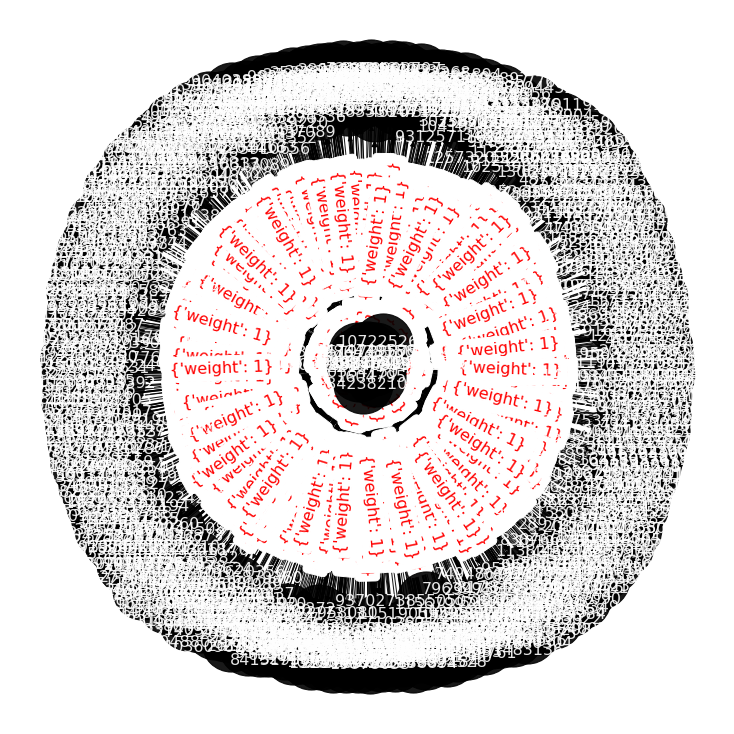

engineers_feed
Nodes: 42, Edges: 85
Average Clustering: 0.334


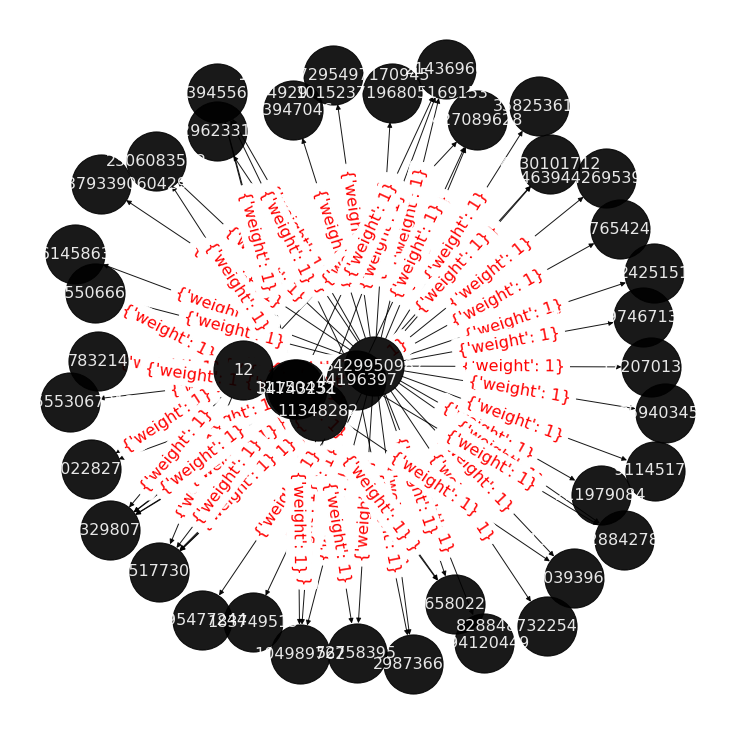

karpathy
Nodes: 678, Edges: 1574
Average Clustering: 0.478


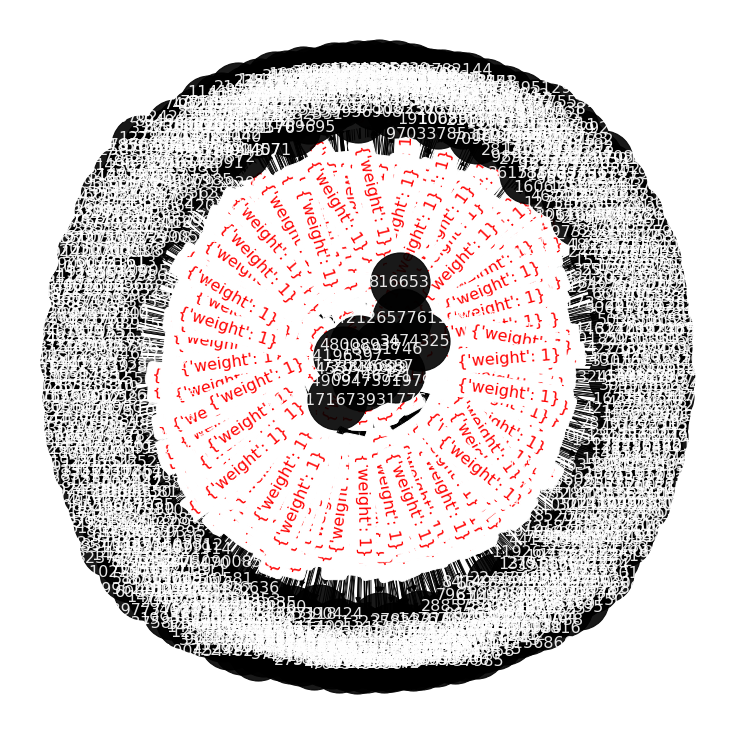

kiraincongress
Nodes: 139, Edges: 138
Average Clustering: 0.0


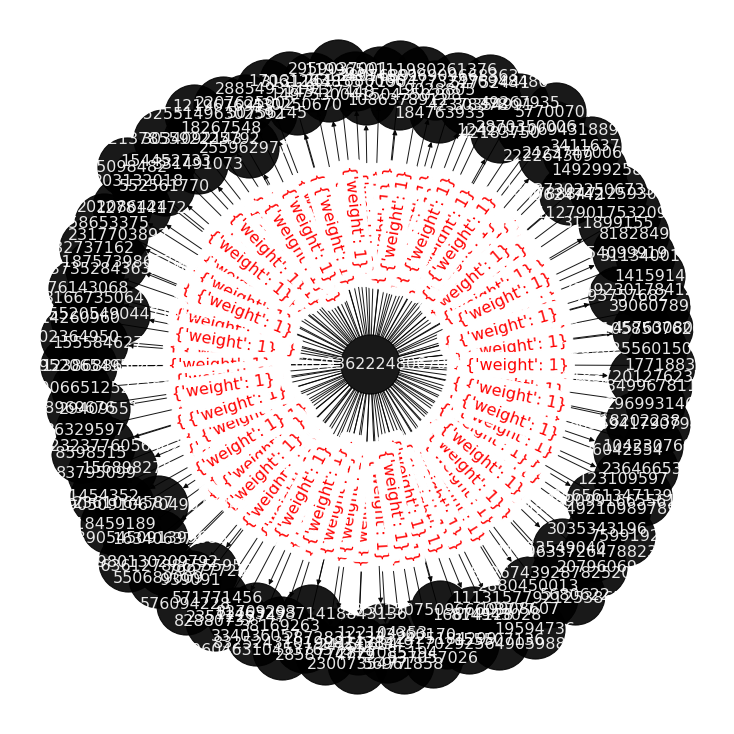

In [10]:
# user_ids = [620047515, 3380357519]
# print(get_user_description(user_ids))
user_names = ['elonmusk', 'ImHardcory', 'engineers_feed', 'karpathy', 'kiraincongress']
user_ids = get_user_ids(user_names)

for i, user_id in enumerate(user_ids):
    G_s, _ = get_ego_graph(G, node=user_id)
    print(f"{user_names[i]}")
    print(f"Nodes: {len(G_s.nodes())}, Edges: {len(G_s.edges())}")
    print(f"Average Clustering: {round(nx.average_clustering(G_s), 3)}")
    # print(f"Small Worldness (>=1): {round(nx.algorithms.smallworld.sigma(G_s.to_undirected(), niter = 5), 3)}"): #takes forever
    draw_graph(G_s, fig_size  = (10, 10))

## **Ranking: Directly using Centrality Metrics**

In [11]:
c_ev = nx.eigenvector_centrality(G) #Katz is better, settling because it takes forever and doesnt converge
c_ev = sorted(c_ev.items(), key=lambda x: x[1], reverse=True)

c_cl = nx.closeness_centrality(G)
c_cl = sorted(c_cl.items(), key=lambda x: x[1], reverse=True)

c_dg = nx.in_degree_centrality(G)
c_dg = sorted(c_dg.items(), key=lambda x: x[1], reverse=True)

In [15]:
c_pg = nx.pagerank(G)
c_pg = sorted(c_pg.items(), key=lambda x: x[1], reverse=True)

In [24]:
top_n = 200
df_ev = pd.DataFrame(c_ev[:top_n], columns = ['user', 'cen_ev'])
# df_cl = pd.DataFrame(c_cl[:top_n], columns = ['user', 'cen_cl'])
df_dg = pd.DataFrame(c_dg[:top_n], columns = ['user', 'cen_dg'])
df_pg = pd.DataFrame(c_pg[:top_n], columns = ['user', 'cen_pg'])

# df_cen = df_ev.merge(df_cl, how='inner')
df_cen = df_ev.merge(df_dg, how='inner')
df_cen = df_cen.merge(df_pg, how='inner')

df_cen['rank_cen_ev'] = df_cen['cen_ev'].rank(pct=True)
# df_cen['rank_cen_cl'] = df_cen['cen_cl'].rank(pct=True)
df_cen['rank_cen_dg'] = df_cen['cen_dg'].rank(pct=True)
df_cen['rank_cen_pg'] = df_cen['cen_pg'].rank(pct=True)

df_cen['rank_combined'] = df_cen.iloc[:, -3:].apply(gmean, axis=1)
df_cen['username'] = df_cen['user'].apply(lambda x: get_user_description(x))
df_cen.sort_values(by='rank_combined', ascending = False, inplace=True)

df_cen[~df_cen.user.isin(df.user.unique())].head(25) #not already following

,user,cen_ev,cen_dg,cen_pg,rank_cen_ev,rank_cen_dg,rank_cen_pg,rank_combined,username
0,116994659,0.071912,0.000428,0.000009,1.000000,0.978261,0.956522,0.978100,[Sam Harris:SamHarrisOrg]
1,106204123,0.069367,0.000367,0.000009,0.978261,0.913043,0.717391,0.862119,[Jonathan Haidt:JonHaidt]
10,15143478,0.053464,0.000288,0.000009,0.782609,0.673913,0.739130,0.730505,[Richard Dawkins:RichardDawkins]
6,15912890,0.057845,0.000271,0.000009,0.869565,0.521739,0.826087,0.720986,[Ayaan Hirsi Ali:Ayaan]
19,5943622,0.050220,0.000332,0.000009,0.586957,0.826087,0.695652,0.696105,[Marc Andreessen:pmarca]
5,88315048,0.059726,0.000262,0.000009,0.891304,0.456522,0.543478,0.604723,[Coleman Hughes:coldxman]
11,1306199515,0.052697,0.000253,0.000009,0.760870,0.423913,0.521739,0.552095,[John McWhorter:JohnHMcWhorter]
35,183749519,0.036684,0.000279,0.000009,0.239130,0.597826,0.891304,0.503205,[Paul Graham:paulg]
26,1282121312,0.043645,0.000253,0.000009,0.434783,0.423913,0.586957,0.476488,[Tim Urban:waitbutwhy]
18,17995040,0.050647,0.000279,0.000009,0.608696,0.597826,0.260870,0.456176,[Ben Shapiro:benshapiro]


In [27]:
df_cen[['rank_cen_ev',  'rank_cen_dg', 'rank_cen_pg', 'rank_combined']].corr()

,rank_cen_ev,rank_cen_dg,rank_cen_pg,rank_combined
rank_cen_ev,1.000000,0.522953,0.186309,0.746544
rank_cen_dg,0.522953,1.000000,0.671511,0.848001
rank_cen_pg,0.186309,0.671511,1.000000,0.748382
rank_combined,0.746544,0.848001,0.748382,1.000000


In [28]:
df_cen.to_csv(f"{CLOUD_STORAGE_BUCKET}/data/processed/node_centrality.csv", index = False)

#### **TODO**
- [ ] Eigenvector centrality matters more, consider weighted mean
- [ ] Node features
- [ ] Edge features by tweet engagement (if available, might need to sample) (hint: entities in tweets?)
    - `get_liking_users`
    - `get_liked_tweets`
    - `get_retweeters`
- [ ] :Consideration: Tweet content paired with ideal prompts in the embedding space
- [ ] :Consideration: Outliers | Downweight certain recommendations?
- [ ] GNNs

## **Play with Torch**

In [12]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

`data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

`data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]` and type torch.long

`data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

`data.y`: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

`data.pos`: Node position matrix with shape `[num_nodes, num_dimensions]`

In [13]:
print(data.keys)
print(data['x'])

['x', 'edge_index']
tensor([[-1.],
        [ 0.],
        [ 1.]])


In [6]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = GCNConv(dataset.num_node_features, 16)
        self.conv_2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv_1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training = self.training)
        x = self.conv_2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8020


## **Appendix**

In [78]:
# nt = Network('500px', '500px')
# nt.from_nx(G)
# nt.show('nx.html')
# client.destroy_friendship(?) #dont need no api for that! hold my beer!

In [90]:
import plotly.graph_objects as go
import networkx as nx
# G = nx.random_geometric_graph(200, 0.125)
edge_x = []
edge_y = []
pos=nx.spring_layout(G_s)
for edge in G_s.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G_s.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Bluered',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

#color nodes
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G_s.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = [np.log(1+x) for x in node_adjacencies]
node_trace.text = node_text


#create graph
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='Twitter Ego Network',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Radius 2",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()
fig.write_html('first_degree.html', auto_open=True)

### **Communities**

In [41]:
from community import community_louvain
TWITTER_USERID = client.get_user(
    username=TWITTER_USERNAME,
    user_fields=["id"],
).data.id
df_following = df.copy().dropna()
df_user = pd.DataFrame({"user": user, "following": df_following.user.unique()})

mul_user = df_following.following.value_counts().reset_index(name="count").query("count > 1")["index"]
df_following = df_following[df_following["following"].isin(mul_user)]
print(df_following.shape, df_user.shape)

df_with_user = pd.concat([df_user, df_following])
print(df_with_user.shape)

DiGraph with 15467 nodes and 51845 edges
DiGraph with 2000 nodes and 1418 edges


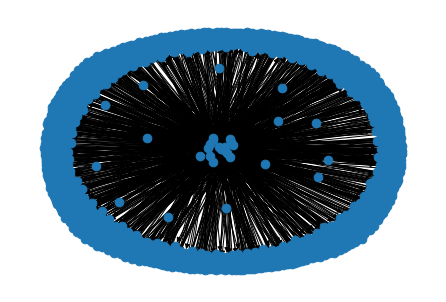

In [65]:
edges_s = df_with_user.copy()
edges_s.columns = ['source', 'target']
edges_s['source'] = edges_s['source'].astype(int)
edges_s['target'] = edges_s['target'].astype(int)

G_s = nx.from_pandas_edgelist(
    edges_s,
    create_using=nx.DiGraph(),
)

print(nx.info(G_s))

# visualize graph

import random
k = 2000
sampled_nodes = random.sample(G_s.nodes, k)
G_v = G_s.subgraph(sampled_nodes)

print(nx.info(G_v))
pos = nx.spring_layout(G_v)
nx.draw(G_v, pos, node_size = 75)
plt.show()

In [75]:
comms = community_louvain.best_partition(G_s.to_undirected())
unique_coms = np.unique(list(comms.values()))
len(unique_coms)

10